In [26]:
#from PyQt5.QtWidgets import *
#from PyQt5.QtGui import *
#from PyQt5.QtCore import Qt
import os
#from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget
import dsp_lib

In [27]:
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np
#import cmath
#import math
#from commpy.filters import rcosfilter
#from ipywidgets import interact, widgets

In [28]:
from scipy.signal import butter, filtfilt
import os
from array import array
def read_signal(file_name, data_type):
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    iq_size_in_bytes = 4
    number_of_int_to_read = file_size // iq_size_in_bytes * 2
    arr = array(data_type)
    with open(file_path, 'rb') as fileobj:
        arr.fromfile(fileobj, number_of_int_to_read)
    i = np.array(arr[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(arr[1:: 2])
    q = q.reshape((len(q), 1))
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten


def find_carr_freq(spectrum, min_sig_lvl):
    idx = list(np.where(spectrum >= min_sig_lvl))
    idx = idx[0]
    f_low = idx[0]
    f_high = idx[-1]
    carr_freq = round((f_low + f_high) / 2)
    return carr_freq


def mixing_signal(signal, freq):
    N = len(signal)
    k = freq
    n = np.arange(0, N, 1)
    mixer = np.exp(-1j * 2 * math.pi * k * n / N)
    mixed_signal = np.multiply(signal, mixer)
    return mixed_signal


def filter_signal(mixed_sig, normal_cutoff):
    order = 2
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sig_filtered = filtfilt(b, a, mixed_sig)
    return sig_filtered

In [29]:
def resampling_lagrange_step_ver(s, step, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    #if (p > 1):
    #    if (q == 1):
    #        y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
    #    else:
    #        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    #else:
    #    y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    if (step > 1):
        y = np.zeros(int((len(s) -1) / step) + 1, dtype=np.csingle)
    else:
        y = np.zeros(int(len(s) / step), dtype=np.csingle) 
    
    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    print(f"len(y) = {len(y)}, len(t) = {len(t)}, len(s) = {len(s)}")

    for k in range(len(y)):
        #x = k * q / p - x0
        x = k * step - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        #print(f"x = {x}, n = {n}, d = {d}")
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1
        #print(f"a0 = {a0} a1 = {a1} a2 = {a2} a3 = {a3}")
        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    #print(t)
    return y

In [30]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [31]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def add_freq(sig, f0_to_fsig):
    n = np.arange(0, len(sig), 1)
    mixer = np.exp(1j * np.pi * f0_to_fsig * n)
    #print(mixer[(821500 - 10 -1) : (821500 - 1)])
    return sig * mixer

In [32]:
def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RRC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf

In [33]:
def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf

In [34]:
def add_phase(sig, phase):
# phase = [-1, 1] [semicircles]
    sig *= np.exp(1j * np.pi * phase)
    return sig

In [35]:
def save_cmplx_sig_to_int16(signal, filename):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    arr_int16_re = s_re.astype(np.int16)
    arr_int16_im = s_im.astype(np.int16)
    arr_int = np.empty(len(two_sigs) * 2, dtype=int)
    print(len(arr_int))
    arr_int[ : : 2] = arr_int16_re
    arr_int[1 : : 2] = arr_int16_im
    saved_arr = arr_int.astype(np.int16)
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

def save_cmplx_sig(signal, filename, data_type='int16'):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    if data_type == 'int16':
        arr_to_type_re = s_re.astype(np.int16)
        arr_to_type_im = s_im.astype(np.int16)
        arr_int = np.empty(len(signal) * 2, dtype=int)
    if data_type == 'float32':
        arr_to_type_re = s_re.astype(np.float32)
        arr_to_type_im = s_im.astype(np.float32)
        arr_int = np.empty(len(signal) * 2, dtype=float)
    if data_type == 'float64':
        arr_to_type_re = s_re.astype(np.float64)
        arr_to_type_im = s_im.astype(np.float64)
        arr_int = np.empty(len(signal) * 2, dtype=np.float64)

    print(len(arr_int))
    arr_int[ : : 2] = arr_to_type_re
    arr_int[1 : : 2] = arr_to_type_im
    if data_type == 'int16':
        saved_arr = arr_int.astype(np.int16)
    if data_type == 'float32':
        saved_arr = arr_int.astype(np.float32)
    if data_type == 'float64':
        saved_arr = arr_int.astype(np.float64)
        
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

In [37]:
def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

In [38]:
# a = [7, 3, 5, 2, 1, 4, 1]
# b = [2, 3, 4, 3, 2, 1]
# conv = np.convolve(a, b, 'same')
# print(conv)

In [39]:
# N = 7
# Fs = 1
# T_symb = 8#1 / sig_board
# s_rc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
# plot_signal_power(s_rc, 0)
#
# N_symb = 2
# sps = 8 # f_sampling / f_symbol (SPS)
# s_qpsk = gen_qpsk_symbols(N_symb, sps)
# print(s_qpsk)
# plot_signal_power(s_qpsk, 1)
#
# qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')
# print(qpsk_rc)
# plot_signal_power(qpsk_rc, 2)

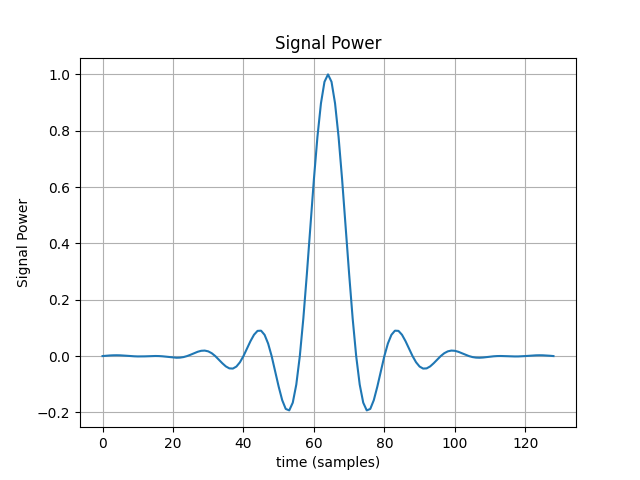

In [40]:
sig_board = 0.168
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rc = gen_rc_filter_impulse_response(N, Fs, T_symb)
plot_signal_power(s_rc, 0)


f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

N_symb = N * 1000
sps = 8 # f_sampling / f_symbol (SPS)
s_qpsk = gen_qpsk_symbols(N_symb, sps)
qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')


In [41]:
mixed_qpsk = add_freq(qpsk_rc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)

In [42]:
two_sigs = mixed_qpsk + qpsk_rc
two_sigs = upscale_to_i16(two_sigs)

(4.541676749702104-1.3178783245346442j)
4.541676749702104
4.5814505563471055
7152.101631786652


In [43]:
save_cmplx_sig(two_sigs, 'qpsk_rc_float32.bid')

2064000
[ 17141  -5569   6216   2977  -3829 -10137   9316 -21710  20713  -8591
   7104   2898  -4121 -10009   8635 -19342  17141  -5569   4677   2944
   -529  -7052  10532  -7781  10488   4939    195   4206   5804  -3889]


129
1
8
(4.237992031416876-1.3914567434194365j)
4.237992031416876
4.2479844261102215
7713.5405202047705
2064000
[ 18697.87791542  -5787.64928534   6672.07781678   3277.52312218
  -4055.41141936 -10893.28104612   9945.37868609 -23214.17535582
  22064.29081344  -9295.9237727    7620.55071617   3026.80383378
  -4539.02943478 -10674.50482964   9047.34772756 -20915.4530484
  18568.76387389  -6237.38443681   5136.27059306   3181.36032043
   -615.43927376  -7739.81499707  11570.99095983  -8574.15481112
  11508.41545555   5449.11158026    183.00270569   4605.72462026
   6376.62430375  -4171.77462694]


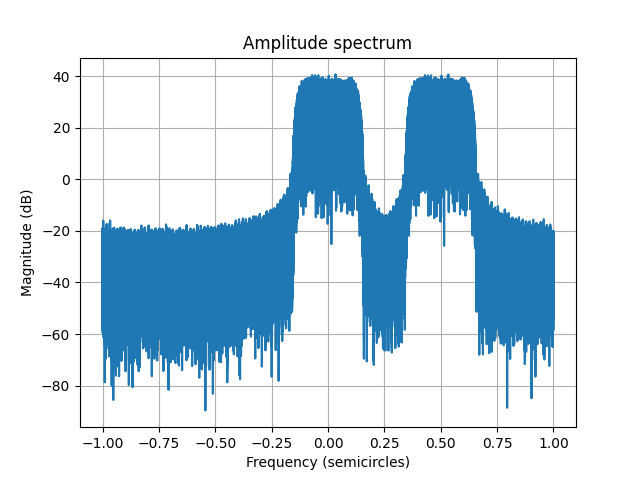

array([[-24.30309322],
       [-48.54320777],
       [-31.04074208],
       ...,
       [-29.13879826],
       [-29.82228019],
       [-25.28101789]])

In [44]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
max(two_sigs)
two_sigs_upsc = upscale_to_i16(two_sigs)
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float.bin', 'float64')
max(two_sigs_upsc)
plot_spectrum(two_sigs_upsc, 10)

129
1
8
(4.237992031416876-1.3914567434194365j)
4.237992031416876
4.2479844261102215
7713.5405202047705
sig len = 1032000
2064000
[ 18697.87791542  -5787.64928534   6672.07781678   3277.52312218
  -4055.41141936 -10893.28104612   9945.37868609 -23214.17535582
  22064.29081344  -9295.9237727    7620.55071617   3026.80383378
  -4539.02943478 -10674.50482964   9047.34772756 -20915.4530484
  18568.76387389  -6237.38443681   5136.27059306   3181.36032043
   -615.43927376  -7739.81499707  11570.99095983  -8574.15481112
  11508.41545555   5449.11158026    183.00270569   4605.72462026
   6376.62430375  -4171.77462694]
2064000
[ 18697.877   -5787.6494   6672.0776   3277.5232  -4055.4114 -10893.281
   9945.379  -23214.176   22064.291   -9295.924    7620.551    3026.804
  -4539.0293 -10674.505    9047.348  -20915.453   18568.764   -6237.3843
   5136.2705   3181.3604   -615.4393  -7739.815   11570.991   -8574.155
  11508.415    5449.112     183.0027   4605.7246   6376.6245  -4171.7744]


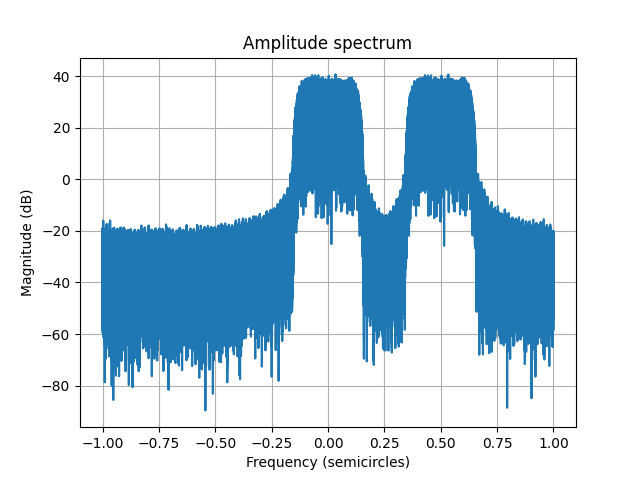

[18697.87791542 -5787.64928534j  6672.07781678 +3277.52312218j
 -4055.41141936-10893.28104612j  9945.37868609-23214.17535582j
 22064.29081344 -9295.9237727j   7620.55071617 +3026.80383378j
 -4539.02943478-10674.50482964j  9047.34772756-20915.4530484j
 18568.76387389 -6237.38443681j  5136.27059306 +3181.36032043j]


In [45]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
two_sigs_upsc = upscale_to_i16(two_sigs)
print(f"sig len = {len(two_sigs_upsc)}")
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float64.bin', 'float64')
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float32.bin', 'float32')
max(two_sigs_upsc)
plot_spectrum(two_sigs_upsc, 10)
print(two_sigs_upsc[:10])

In [46]:
qpsk_rrc_rrc = np.convolve(two_sigs_upsc, s_rrc, 'same')
print(two_sigs_upsc[:10])
print(s_rrc)
print(qpsk_rrc_rrc[:10])
print(qpsk_rrc_rrc[len(qpsk_rrc_rrc) - 10::])
# samples_32 = dsp_lib.read_signal('qpsk_rrc_float32.bin', 'float32')
# sig32 = dsp_lib.make_cmplx_sig(samples_32)
# print(sig32[:10])

[18697.87791542 -5787.64928534j  6672.07781678 +3277.52312218j
 -4055.41141936-10893.28104612j  9945.37868609-23214.17535582j
 22064.29081344 -9295.9237727j   7620.55071617 +3026.80383378j
 -4539.02943478-10674.50482964j  9047.34772756-20915.4530484j
 18568.76387389 -6237.38443681j  5136.27059306 +3181.36032043j]
[-5.27526056e-03 -3.99102742e-03 -1.64842729e-03  1.29551186e-03
  4.20829446e-03  6.41713384e-03  7.36294421e-03  6.73849224e-03
  4.57739857e-03  1.26984331e-03 -2.50378491e-03 -5.91158303e-03
 -8.15394430e-03 -8.65281056e-03 -7.20253053e-03 -4.04416717e-03
  1.59973235e-04  4.45338056e-03  7.79222114e-03  9.28996172e-03
  8.44532739e-03  5.29838667e-03  4.71398168e-04 -4.92610836e-03
 -9.51895698e-03 -1.19753744e-02 -1.13400852e-02 -7.31607595e-03
 -4.23543130e-04  8.01507220e-03  1.60811386e-02  2.16328990e-02
  2.27812262e-02  1.83734040e-02  8.37737184e-03 -5.93206756e-03
 -2.20523040e-02 -3.66153950e-02 -4.59937904e-02 -4.70527982e-02
 -3.79107833e-02 -1.85494904e-02  8

In [47]:
print(qpsk_rrc_rrc[:10])

[43303.06478697-35364.5686564j  51747.25356765-47462.61486115j
 59003.30129113-58870.07737071j 64554.8413312 -68610.59021201j
 68209.76950356-75762.74078863j 69907.26111333-79472.02893133j
 69755.73180095-79259.12593711j 68207.70760575-74916.96324451j
 65747.47414961-66385.86054275j 62750.43111299-54079.31619223j]


[18697.87791542 -5787.64928534j  6672.07781678 +3277.52312218j
 -4055.41141936-10893.28104612j  9945.37868609-23214.17535582j
 22064.29081344 -9295.9237727j   7620.55071617 +3026.80383378j
 -4539.02943478-10674.50482964j  9047.34772756-20915.4530484j
 18568.76387389 -6237.38443681j  5136.27059306 +3181.36032043j]
(121042.19035425548+1329.2877303291896j)
121042.19035425548
121081.54807305771
0.270619268761159
2064000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


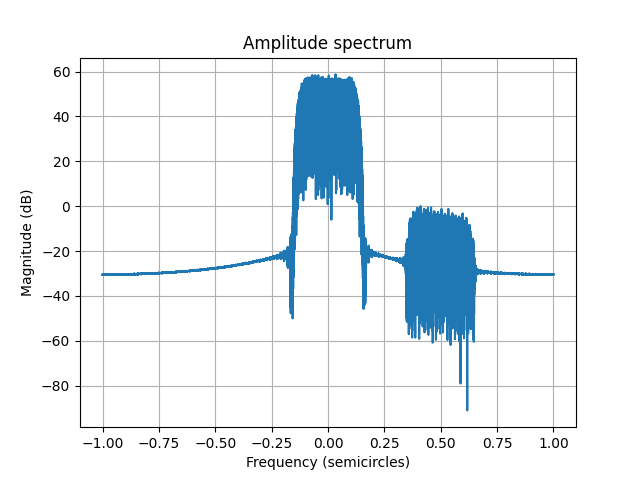

array([[-30.55141221],
       [-30.45663538],
       [-30.41442251],
       ...,
       [-30.49077348],
       [-30.43032708],
       [-30.40514285]])

In [48]:
qpsk_rrc_rrc = np.convolve(two_sigs_upsc, s_rrc, 'same')
print(two_sigs_upsc[:10])

two_sigs_upsc_i16 = upscale_to_i16(qpsk_rrc_rrc)
save_cmplx_sig_to_int16(two_sigs_upsc_i16, 'qpsk_rrc_rrc_int16_.bin')

plot_spectrum(qpsk_rrc_rrc, 1)


(1.95332457732921+1.252543811985356j)
1.95332457732921
1.95332457732921
16774.98987126987


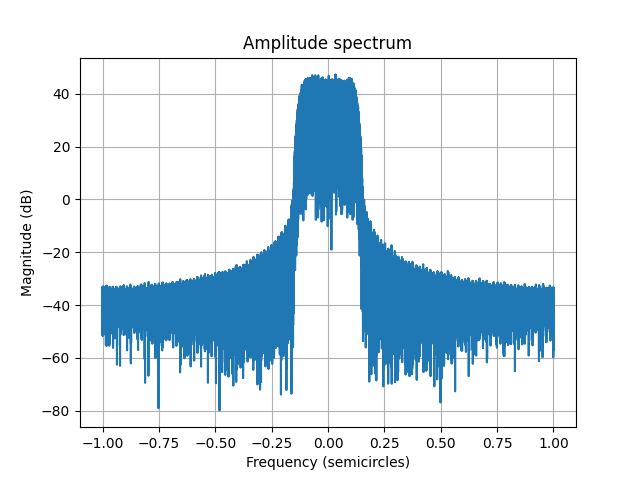

array([[-35.58038911],
       [-39.50272213],
       [-40.86427319],
       ...,
       [-37.0040165 ],
       [-39.13599968],
       [-45.02601134]])

In [49]:
qpsk_upsc = upscale_to_i16(qpsk_rc)
plot_spectrum(qpsk_upsc, 2)

In [50]:
save_cmplx_sig_to_int16(qpsk_upsc, 'qpsk_rc_int16_1_sig.bin')

2064000
[ 16774 -16774  18034 -18945  18839 -20702  19197 -21909  19157 -22451
  18793 -22240  18204 -21224  17496 -19391  16774 -16774  16113 -13427
  15610  -9489  15315  -5111  15251   -474  15410   4228  15756   8797]
